In [10]:
# Import packages, the Y-matrix for the dataset and Functions.py
import numpy as np
%run Dolphins_data_import.ipynb
import sys
sys.path.append('../')
from Functions import * 
import copy

In [11]:
dim = 2

# Define mu and cov_matrix to be able to sample #num_samples samples from a multivariate normal distribution
mu = np.zeros(dim) 
identity_matrix = np.eye(dim) 
cov_matrix = identity_matrix 
num_samples = 62 

points = {l+1: np.random.multivariate_normal(mu, cov_matrix) for l in range(num_samples)}

In [12]:
# Adding stopping criteria
MLL_final = np.zeros(len(Y)) # Define the MLL
grad_sum_final = np.zeros(len(Y)) # Define the gradient sum
s = 0
alpha = 5 # change alpha here

True_posetiv = 0
True_negativ = 0
False_posetiv = 0
False_negativ = 0


for t in range(len(Y)):
    if Y[t][0] == 1:
        points_copy = copy.deepcopy(points)

        Y_test = Y[t]
        Y_train = copy.deepcopy(Y)
        Y_train[t][0] = -1

        prev_grad = 200
        grad = 0
        k = 0
        n = 100000
        MLL = np.zeros(n) # Define the MLL
        grad_sum = np.zeros(n) # Define the gradient sum

        while abs(prev_grad - grad) > 0.01: # stopping criteria
            prev_grad = grad
            for i in range(1,num_samples+1): # Run over number of num_samples
                for j in range(dim): # Run over dimension
                    grad_now = Gradient_function_fast(i,j,Y_train,points_copy,alpha)
                    grad_sum[k] += grad_now**2
                    points_copy[i][j] += LR(k)*grad_now # Use Gradient_function and take step=0.1*grad
            grad = grad_sum[k]
            MLL[k] = Loss_function_fast(points_copy,Y_train,alpha) # Calcualte the probability using Loss_function
            k += 1
   
        MLL_final[s] = MLL[k-1]
        grad_sum_final[s] = grad_sum[k-1]

        connection = Y_test[0] 
        point_a = points_copy[Y_test[1]]
        point_b = points_copy[Y_test[2]]
        distance = np.linalg.norm(point_a - point_b) ** 2 
        sigmoid_value = 1 / (1 + np.exp(-connection * (alpha - distance))) 

        if sigmoid_value > 0.5:
            True_posetiv += 1
        else: 
            False_negativ += 1

        s += 1
    print(t)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [53]:
k

44

In [13]:
True_posetiv

38

In [14]:
False_negativ

121

In [15]:
Loss_function(points,Y_train, "norm",alpha)

-3966.443776235015

In [16]:
1 / (1 + np.exp(-connection * (5 - np.linalg.norm(points[Y_test[1]] - points[Y_test[2]]) ** 2)))  

0.9901643014119749

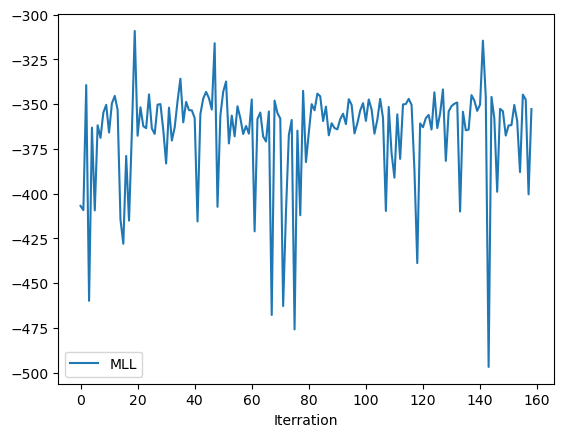

In [17]:
plt.plot(MLL_final[0:s],label='MLL')
#plt.plot(np.sqrt(grad_sum_final[0:s]), label='Gradient sum')
#plt.ylabel('MLL')
plt.xlabel('Iterration')
plt.legend()
plt.show()

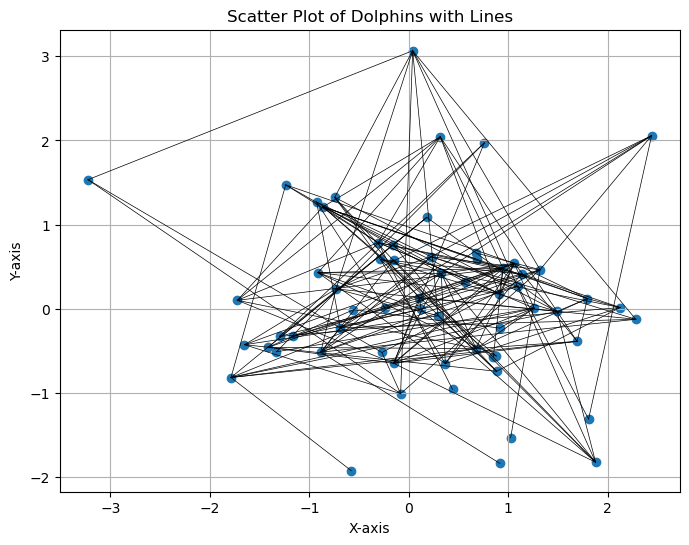

In [9]:
plt.figure(figsize=(8, 6))

for m in range(len(Y)): 
    if Y[m][0] == 1: # Check if there is a connection between Y[m][1] and Y[m][2]
        point1 = points[Y[m][1]]
        point2 = points[Y[m][2]]
        plt.plot([point1[0], point2[0]], [point1[1], point2[1]], color='black', linewidth=0.5) # Ad a line between Y[m][1] and Y[m][2]

# extract the points and plot them
x = [point[0] for point in points.values()]
y = [point[1] for point in points.values()]
plt.scatter(x, y)

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot of Dolphins with Lines')
plt.grid(True)
plt.show()